# Transfer Learning for Jet Tagging in Particle Physics: FCNN

This is the first accompanying notebook for our final project for the CSCI 2470: Deep Learning course. Here, we will present appropriate visualizations of our input data, build and train our models, and present appropriate visualizations of the outputs and results.

*Authors: Jade Ducharme, Egor Serebriakov, Aditya Singh, Anthony Wong*

## Background

Particle accelerator experiments at CERN produce massive amounts of data which non-ML analysis methods struggle to keep up with. A subset of these experiments concerns particle jets, which are streams of secondary particles created during the high energy collision of primary particles. Given a particle jet, we wish to rapidly identify the primary particles responsible for the jet in order to determine whether the experiment should be kept for further analysis.

Datastreams produced by these experiments contain "high-quality" information that would require massive amounts of memory to store. Our goal is then the following: can we train a "student" Neural Network to take in reduced, "low-quality" jet data and predict the primary particles that initiated the jet with the same accuracy as a "teacher" model trained on high-quality jet data? More simply, we will be performing a binary classification task to see whether our model can predict if the jet was initiated by a Top Quark ```label: 1``` or a "background" particle ```label: 0```.

Our code makes use of the [ATLAS Top Tagging Open Data Set](https://opendata.cern.ch/record/15013), a set of simulated jet events created by the ATLAS Collaboration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchmetrics
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import seaborn as sns
from preprocess import *
from helper import *

import warnings
warnings.filterwarnings('ignore')  # pesky divide-by-zero errors

sns.set_theme()
plt.style.use("seaborn-v0_8")

#### Input Data Visualization

As a very first step, let's load in our data to see what it looks like. Our data has three attributes: "jet", "constituents", and "high-level" information about each jet. The jet attribute stores information about the *entire* jet: for example, the jet's mass and momentum. Meanwhile, the constituent attribute stores information about *each individual* particle that compose the jet: each particle's mass and momentum, for example. Finally, the high-level attribute stores variables "chosen in two separate studies of high level quantity based top taggers carried out by the ATLAS collaboration" (from the [reference manual](https://gitlab.cern.ch/atlas/ATLAS-top-tagging-open-data/-/tree/master?ref_type=heads)). These high-level variables aren't super important, and we instead wish to train our model on the constituent attributes, which provide the most information to identify our jets.

In [2]:
jet_data, jet_labels, jet_weights, jet_features = get_data("./data/reduced_atlas_dataset.h5", attribute="jet")
cons_data, cons_labels, cons_weights, cons_features = get_data("./data/reduced_atlas_dataset.h5", attribute="constituents")

print("---------- Jet-level data ----------------")
print("Data shape [input_size, num_features]:", jet_data.shape)
print("Feature names:", [human_feature(f) for f in jet_features],"\n")

print("---------- Constituent-level data ----------------")
print("Data shape [input_size, num_features, num_constituents]:", cons_data.shape)
print("Feature names:", [human_feature(f) for f in cons_features])

---------- Jet-level data ----------------
Data shape [input_size, num_features]: (10000, 4)
Feature names: ['jet pseudo-rapidity', 'jet mass', 'jet azimuthal angle', 'jet transverse momentum'] 

---------- Constituent-level data ----------------
Data shape [input_size, num_features, num_constituents]: (10000, 4, 80)
Feature names: ['constituent energy', 'constituent pseudo-rapidity', 'constituent azimuthal angle', 'constituent transverse momentum']


As we can see, our features contain some important information about the jets: mass, energy, momentum, etc. We can visualize these features in a histogram:

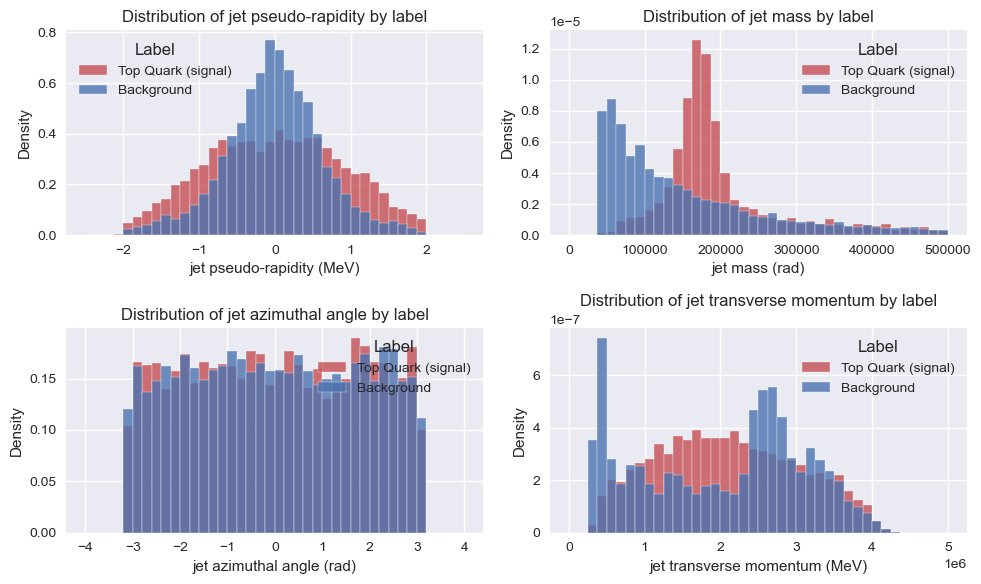

In [3]:
from visualize import *

plot_1D_distributions(jet_data, jet_labels, jet_features, nbins=40)

This histogram shows the distribution of jet mass, pseudo-rapidity, azimuthal angle, and energy by label. The human eye can clearly distinguish some patterns here! Now, let's see what the constituents' histograms look like:

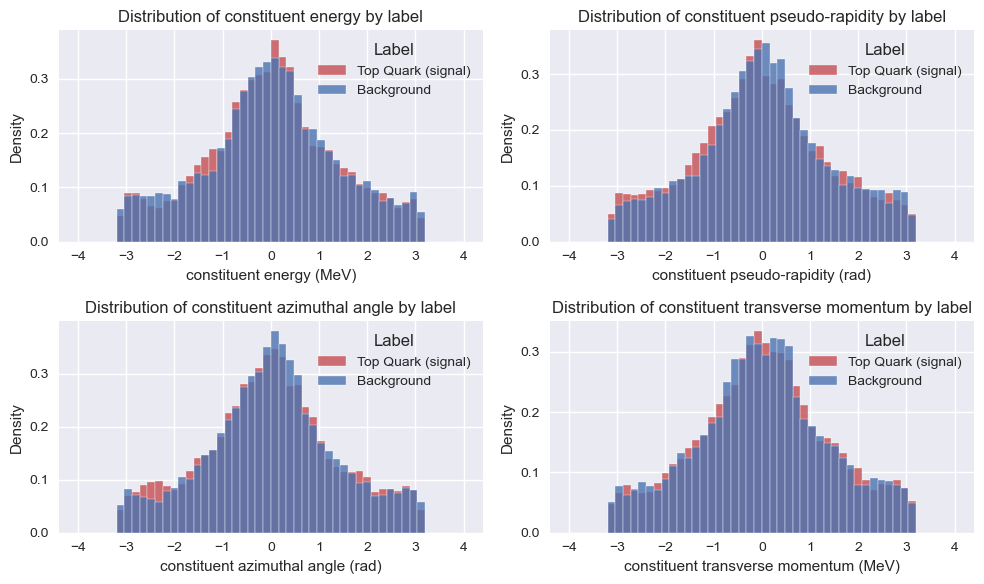

In [4]:
plot_1D_distributions(cons_data, cons_labels, cons_features, nbins=50)

At the constituent level, it is much harder (even for the human eye) to distinguish the signal curve from the background curve. Let's hope a neural network can help us with this!

### Preprocessing

The raw constituent-level data is unsuitable for training a deep neural network. First, the dynamic range in the energy and momentum needs to be accounted for. Next, the $\eta$ and $\phi$ don't contribute much information in their raw state, and must be transformed using the physically appropriate equations. This is done via the ```preprocess.consituent_preprocess``` function, adapted directly from the ATLAS collaboration.

In [5]:
pre_cons_data, pre_cons_features = constituent_preprocess(cons_data, cons_features)

print("Preprocessed constituent data shape:", pre_cons_data.shape)
print("Preprocessed features:", pre_cons_features)

Preprocessed constituent data shape: (10000, 80, 7)
Preprocessed features: ['delta_eta' 'delta_phi' 'log_pt' 'log_E' 'lognorm_pt' 'lognorm_E' 'R']


Might as well try to visualize our new features!

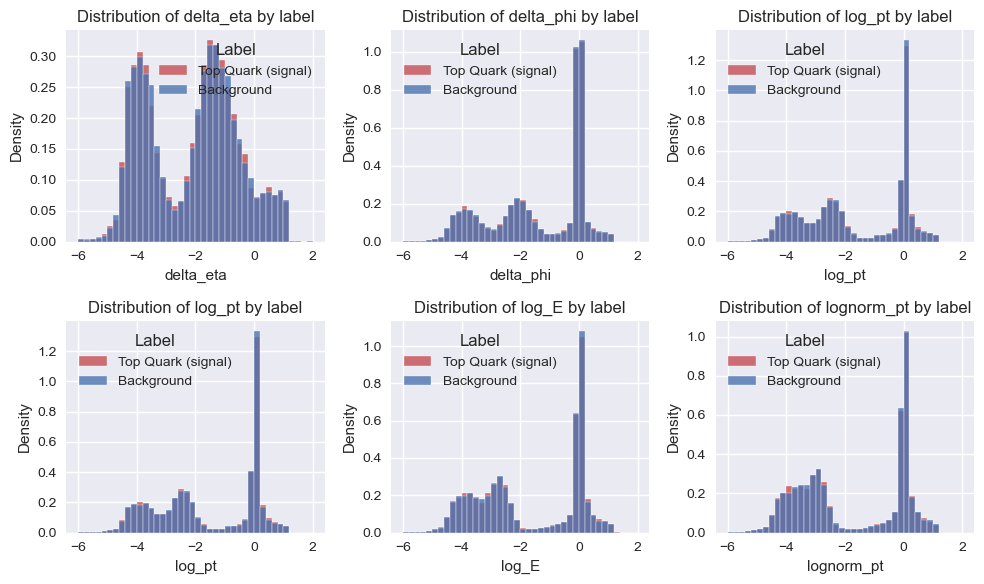

In [6]:
plot_preprocessed_1D_distributions(pre_cons_data, cons_labels, pre_cons_features, nbins=40)

It's getting a little abstract, but the main point is that these modified features should help our network perform better!

### Stage 1: Transfer Learning via FCNN

As a first step, we would like to ensure that we understand how to implement transfer learning. For this purpose, we will train a simple Teacher FCNN on the high quality ATLAS dataset. Next, we will downgrade this data via diffusion, transfer knowledge from the Teacher to the Student FCCN, and train this Student on the lower quality data. We will then compare their performances.

First, we will train the Teacher FCNN on constituent-level data.

In [7]:
from model import TeacherFCNN, train_one_epoch, test

# model initialization
teacher_fcnn = TeacherFCNN(num_features=int(pre_cons_data.shape[1]*pre_cons_data.shape[2]))
criterion = nn.BCELoss(reduction='none')    
optimizer = optim.Adam(teacher_fcnn.parameters(), lr=1.2e-5, weight_decay=1e-5)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device,"\n")
teacher_fcnn.to(device)

# Data preparation
train_set, val_set, test_set = standardize_split(pre_cons_data, cons_labels, cons_weights, train_split=0.7, val_split=0.15)
train_loader = DataLoader(train_set, batch_size=12, shuffle=True)
val_loader = DataLoader(val_set, batch_size=12, shuffle=True)
test_loader = DataLoader(test_set, batch_size=12, shuffle=True)

loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

num_epochs = 50
for epoch in range(1,num_epochs+1):

    # training
    loss, acc = train_one_epoch(teacher_fcnn, device, train_loader, optimizer, criterion)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = test(teacher_fcnn, device, val_loader, criterion)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if epoch%5 == 0:
      print(f"Epoch {epoch:02d}\t Train loss: {loss:.4f}\t Train acc: {acc:.4f}\t"\
            + f"Val loss: {val_loss:.4f}\t Val acc: {val_acc:.4f}"
      )

Device: cpu 

Epoch 05	 Train loss: 0.7926	 Train acc: 0.5100	Val loss: 0.6941	 Val acc: 0.5080
Epoch 10	 Train loss: 0.7911	 Train acc: 0.5037	Val loss: 0.6915	 Val acc: 0.4827
Epoch 15	 Train loss: 0.7920	 Train acc: 0.4936	Val loss: 0.6948	 Val acc: 0.4860
Epoch 20	 Train loss: 0.7702	 Train acc: 0.5096	Val loss: 0.6918	 Val acc: 0.5013
Epoch 25	 Train loss: 0.7664	 Train acc: 0.5016	Val loss: 0.6950	 Val acc: 0.4987
Epoch 30	 Train loss: 0.7597	 Train acc: 0.5106	Val loss: 0.6929	 Val acc: 0.4973
Epoch 35	 Train loss: 0.7533	 Train acc: 0.5114	Val loss: 0.6894	 Val acc: 0.5067
Epoch 40	 Train loss: 0.7526	 Train acc: 0.4953	Val loss: 0.6906	 Val acc: 0.4887
Epoch 45	 Train loss: 0.7502	 Train acc: 0.5110	Val loss: 0.6927	 Val acc: 0.4973
Epoch 50	 Train loss: 0.7534	 Train acc: 0.5040	Val loss: 0.6908	 Val acc: 0.4753


In [8]:
# Testing on unseen data...

test_loss, test_acc = test(teacher_fcnn, device, test_loader, criterion)

print(f"Final test loss: {test_loss:.4f}\t Final test acc: {test_acc:.4f}"
        )

Final test loss: 0.6999	 Final test acc: 0.5067


#### Visualization

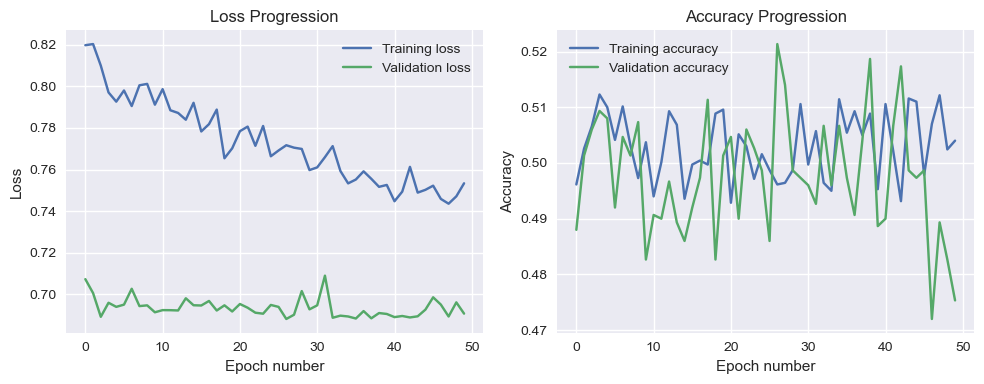

In [9]:
from visualize import plot_loss_and_accuracy

plot_loss_and_accuracy(loss_list, val_loss_list, acc_list, val_acc_list)

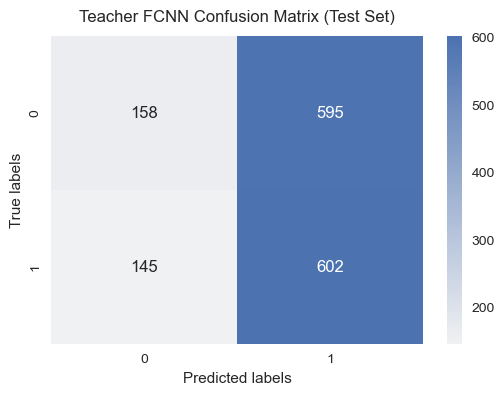

In [10]:
from visualize import plot_confusion_matrices

true = []
pred = []
for d, l, w in test_set:
    d = d.unsqueeze(0)  # at the batch dimension that the model expects
    true.append(int(l))
    pred.append(round(teacher_fcnn(d).item()))

plot_confusion_matrices(true, pred, "Teacher FCNN")

It is somewhat expected to observe subpar performance using a dense network since it is not the most suitable way to represent our data.

#### Degrade Data Quality

Next, we would like to train our Student network using the lower quality data. To obtain this lower quality data, we will simply take our available ("high-quality") data and diffuse it along the Energy axis (or along any specified set of features; energy is just the most physically relevant one).

In [11]:
from helper import diffuse

diffused_cons_data = diffuse(cons_data, cons_features, noise_std=2, apply_features=['fjet_clus_E'])

We can visualize the results in a 1D histogram, shown below:

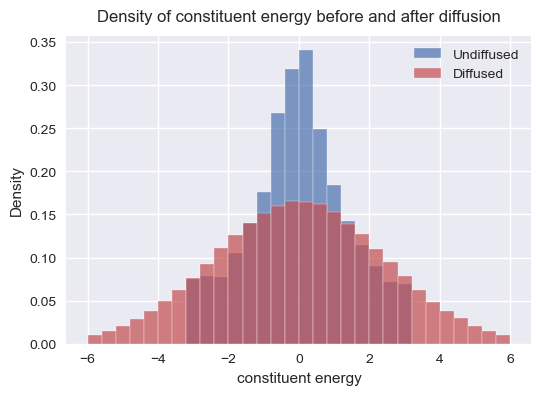

In [12]:
from visualize import plot_diffused_histogram

plot_diffused_histogram(cons_data, diffused_cons_data, cons_features, plot_feature='fjet_clus_E', xrange=[-6,6])

Next, we want to train our Student model using this diffused data. To allow for a fair comparison, our Student network will have the same architecture and hyperparameters as the Teacher model.

In [13]:
from model import StudentFCNN
# run preprocessing again using the diffused data
diff_pre_cons_data, _ = constituent_preprocess(diffused_cons_data, cons_features)

# model initialization
student_fcnn = StudentFCNN(num_features=int(diff_pre_cons_data.shape[1]*diff_pre_cons_data.shape[2]))
student_fcnn.to(device)

# Data preparation
train_set, val_set, test_set = standardize_split(diff_pre_cons_data, cons_labels, cons_weights, train_split=0.7, val_split=0.15)
train_loader = DataLoader(train_set, batch_size=12, shuffle=True)
val_loader = DataLoader(val_set, batch_size=12, shuffle=True)
test_loader = DataLoader(test_set, batch_size=12, shuffle=True)

loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

num_epochs = 50
for e in range(1,num_epochs+1):

    # training
    loss, acc = train_one_epoch(student_fcnn, device, train_loader, optimizer, criterion)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = test(student_fcnn, device, val_loader, criterion)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if e%5 == 0:
      print(f"Epoch {e:02d}\t Train loss: {loss:.4f}\t Train acc: {acc:.4f}\t"\
            + f"Val loss: {val_loss:.4f}\t Val acc: {val_acc:.4f}"
      )

Epoch 05	 Train loss: 0.7130	 Train acc: 0.4937	Val loss: 0.6971	 Val acc: 0.4787
Epoch 10	 Train loss: 0.7026	 Train acc: 0.5091	Val loss: 0.6978	 Val acc: 0.4813
Epoch 15	 Train loss: 0.7085	 Train acc: 0.5134	Val loss: 0.6975	 Val acc: 0.4800
Epoch 20	 Train loss: 0.7169	 Train acc: 0.4933	Val loss: 0.6955	 Val acc: 0.4800
Epoch 25	 Train loss: 0.7095	 Train acc: 0.5064	Val loss: 0.6962	 Val acc: 0.4820
Epoch 30	 Train loss: 0.7088	 Train acc: 0.4997	Val loss: 0.6977	 Val acc: 0.4833
Epoch 35	 Train loss: 0.7146	 Train acc: 0.4969	Val loss: 0.6962	 Val acc: 0.4827
Epoch 40	 Train loss: 0.7131	 Train acc: 0.4951	Val loss: 0.6956	 Val acc: 0.4840
Epoch 45	 Train loss: 0.7117	 Train acc: 0.4971	Val loss: 0.6996	 Val acc: 0.4833
Epoch 50	 Train loss: 0.7113	 Train acc: 0.4963	Val loss: 0.6970	 Val acc: 0.4880


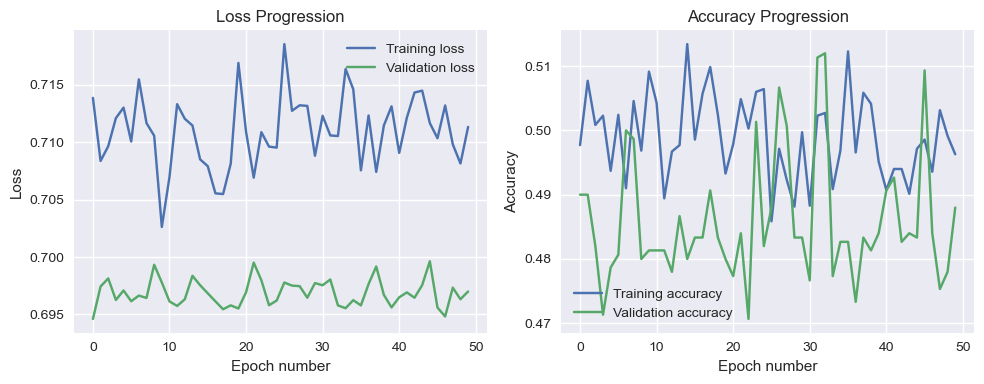

In [14]:
plot_loss_and_accuracy(loss_list, val_loss_list, acc_list, val_acc_list)

It wasn't learning much with the original data, but we see that the results are decidedly worse with the diffused data. It doesn't even overfit anymore! Let's see if some transfer of knowledge can help...

#### Transfer Learning from the Teacher to the Student FCNN

In [15]:
# TODO!